# Imports

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.express as px
import plotly.graph_objects as go
sns.set(rc={'figure.figsize':(25,10)})
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
import holidays
from sklearn.metrics import mean_absolute_error

# Import prepared DF

In [25]:
# Load prepared dataset
df_days = pd.read_csv("../prepared_data/01_06_2021_to_20_06_2023_prepared_df_206.csv")

import numpy as np

df_days.rename(columns={'holidays': 'holiday_indicator'}, inplace=True)

print(df_days.head())

         date  nb_cars  nb_cars_cxl  nb_bookings  nb_bookings_cxl  \
0  2021-06-01       16            1            9                0   
1  2021-06-02       18            1           10                0   
2  2021-06-03       21            1           13                3   
3  2021-06-04       22            1           38                3   
4  2021-06-05       50            4           18                0   

   hourly rate  WE package  1 week package  1 month package  other package  \
0            9           1               6                0              0   
1           11           0               7                0              0   
2           14           0               7                0              0   
3           12           0              10                0              0   
4           20          23               7                0              0   

   ...  12H à 15H  0H à 6H  18H à 24H  +24h  06:00 24:00  00:30 06:00  \
0  ...          1        2          0    16

# Prophet nb of cars

## Just the nb of cars as y

In [26]:
df_prophet_cars = df_days[['date', 'nb_cars']]
df_prophet_cars = df_prophet_cars.rename(columns={'date': 'ds', 'nb_cars': 'y'})
df_prophet_cars.head()


,ds,y
0,2021-06-01,16
1,2021-06-02,18
2,2021-06-03,21
3,2021-06-04,22
4,2021-06-05,50


In [27]:
# Define the split percentages
train_percentage = 0.9
test_percentage = 0.05
validation_percentage = 0.05

# Calculate the number of rows for each set
total_rows = len(df_prophet_cars)
train_rows = int(total_rows * train_percentage)
test_rows = int(total_rows * test_percentage)
validation_rows = total_rows - train_rows - test_rows

# Split the data into train, test, and validation sets
train_set = df_prophet_cars[:train_rows]
test_set = df_prophet_cars[train_rows:train_rows + test_rows]
validation_set = df_prophet_cars[train_rows + test_rows:]

print("train_rows:", train_rows)
print("test_rows:", test_rows)
print("validation_rows:", validation_rows)
print()

train_rows: 675
test_rows: 37
validation_rows: 38



In [28]:
model = Prophet()
model.fit(df_prophet_cars)

# Create future dates for the test and validation periods
future_test = model.make_future_dataframe(periods=len(test_set))
future_validation = model.make_future_dataframe(periods=len(validation_set))

# Predict on the test and validation sets
forecast_test = model.predict(future_test)
forecast_validation = model.predict(future_validation)


22:37:50 - cmdstanpy - INFO - Chain [1] start processing
22:37:50 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
# Calculate RMSE for the test set
y_true_test = test_set['y']
y_pred_test = forecast_test['yhat'].tail(len(test_set))
rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
print("RMSE for the test set:", rmse_test)

RMSE for the test set: 32.302693942597344


In [30]:
mape_test = mean_absolute_percentage_error(y_true_test, y_pred_test) * 100
print("MAPE for the test set:", mape_test)

MAPE for the test set: 52.19668151535396


In [31]:
# Calculate MAE for the test set
y_true_test = test_set['y']
y_pred_test = forecast_test['yhat'].tail(len(test_set))
mae_test = mean_absolute_error(y_true_test, y_pred_test)
print("MAE for the test set:", mae_test)

MAE for the test set: 25.440139130553874


## Forecast nb of cars with french holidays (from holidays package)

In [32]:
df_prophet_cars = df_days.drop(['nb_cars_cxl', 'nb_bookings', 'nb_bookings_cxl'], axis=1)
df_prophet_cars = df_prophet_cars.rename(columns={'date': 'ds', 'nb_cars': 'y'})

# Add the 'holiday' column
fr_holidays = holidays.France()
df_prophet_cars['holiday'] = df_prophet_cars['ds'].apply(lambda x: x in fr_holidays)
df_prophet_cars['ds'] = pd.to_datetime(df_prophet_cars['ds'])

# Create a separate DataFrame for holidays
holidays_df = df_prophet_cars[df_prophet_cars['holiday']]
holidays_df['holiday'] = 'Holiday'

model = Prophet(holidays=holidays_df)
model.fit(df_prophet_cars)

# Create future dates (365 days)
future = model.make_future_dataframe(periods=365)
future.tail()

# Predict
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# Calculate train, test, validation sets and evaluate accuracy
train_percentage = 0.9
test_percentage = 0.05
validation_percentage = 0.05

total_rows = len(df_prophet_cars)
train_rows = int(total_rows * train_percentage)
test_rows = int(total_rows * test_percentage)
validation_rows = total_rows - train_rows - test_rows

train_set = df_prophet_cars[:train_rows]
test_set = df_prophet_cars[train_rows:train_rows + test_rows]
validation_set = df_prophet_cars[train_rows + test_rows:]

model = Prophet(holidays=holidays_df)
model.fit(train_set)

future_test = model.make_future_dataframe(periods=len(test_set))
future_validation = model.make_future_dataframe(periods=len(validation_set))

forecast_test = model.predict(future_test)
forecast_validation = model.predict(future_validation)

y_true_test = test_set['y']
y_pred_test = forecast_test['yhat'].tail(len(test_set))
rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))





/var/folders/gn/32bg35111_q711w0ydw7_2rc0000gp/T/ipykernel_66835/641127344.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidays_df['holiday'] = 'Holiday'
/Users/anaisetienne/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/prophet/forecaster.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
22:37:50 - cmdstanpy - INFO - Chain [1] start processing
22:37:50 - cmdstanpy - INFO - Chain [1] done processing
/Users/anaisetienne/

In [33]:
print("RMSE for the test set:", rmse_test)

mape_test = mean_absolute_percentage_error(y_true_test, y_pred_test) * 100
print("MAPE for the test set:", mape_test)

# Calculate MAE for the test set
y_true_test = test_set['y']
y_pred_test = forecast_test['yhat'].tail(len(test_set))
mae_test = mean_absolute_error(y_true_test, y_pred_test)
print("MAE for the test set:", mae_test)

RMSE for the test set: 19.845785855902257
MAPE for the test set: 25.162890348681334
MAE for the test set: 16.101856813405625


In [34]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Holiday,Holiday_lower,Holiday_upper,additive_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-06-01,38.869569,15.595902,55.976622,38.869569,38.869569,0.0,0.0,0.0,-2.403810,...,-13.516406,-13.516406,-13.516406,11.112596,11.112596,11.112596,0.0,0.0,0.0,36.465759
1,2021-06-02,38.897054,21.902460,62.952579,38.897054,38.897054,0.0,0.0,0.0,2.389170,...,-8.659457,-8.659457,-8.659457,11.048627,11.048627,11.048627,0.0,0.0,0.0,41.286225
2,2021-06-03,38.924539,20.673751,62.185656,38.924539,38.924539,0.0,0.0,0.0,2.224181,...,-8.663610,-8.663610,-8.663610,10.887791,10.887791,10.887791,0.0,0.0,0.0,41.148720
3,2021-06-04,38.952025,18.967628,60.741625,38.952025,38.952025,0.0,0.0,0.0,1.020405,...,-9.617599,-9.617599,-9.617599,10.638004,10.638004,10.638004,0.0,0.0,0.0,39.972430
4,2021-06-05,38.979510,46.054056,86.818704,38.979510,38.979510,0.0,0.0,0.0,27.825164,...,17.516210,17.516210,17.516210,10.308954,10.308954,10.308954,0.0,0.0,0.0,66.804674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,2024-06-15,63.117785,66.957877,107.995036,59.905071,66.496463,0.0,0.0,0.0,22.776000,...,17.516210,17.516210,17.516210,5.259790,5.259790,5.259790,0.0,0.0,0.0,85.893785
1111,2024-06-16,63.121776,78.408548,118.743346,59.894610,66.514915,0.0,0.0,0.0,36.323051,...,31.454987,31.454987,31.454987,4.868064,4.868064,4.868064,0.0,0.0,0.0,99.444827
1112,2024-06-17,63.125767,38.642650,80.634206,59.891282,66.533366,0.0,0.0,0.0,-3.988134,...,-8.514125,-8.514125,-8.514125,4.525990,4.525990,4.525990,0.0,0.0,0.0,59.137633
1113,2024-06-18,63.129758,33.452670,75.137743,59.877770,66.551818,0.0,0.0,0.0,-9.280884,...,-13.516406,-13.516406,-13.516406,4.235522,4.235522,4.235522,0.0,0.0,0.0,53.848874


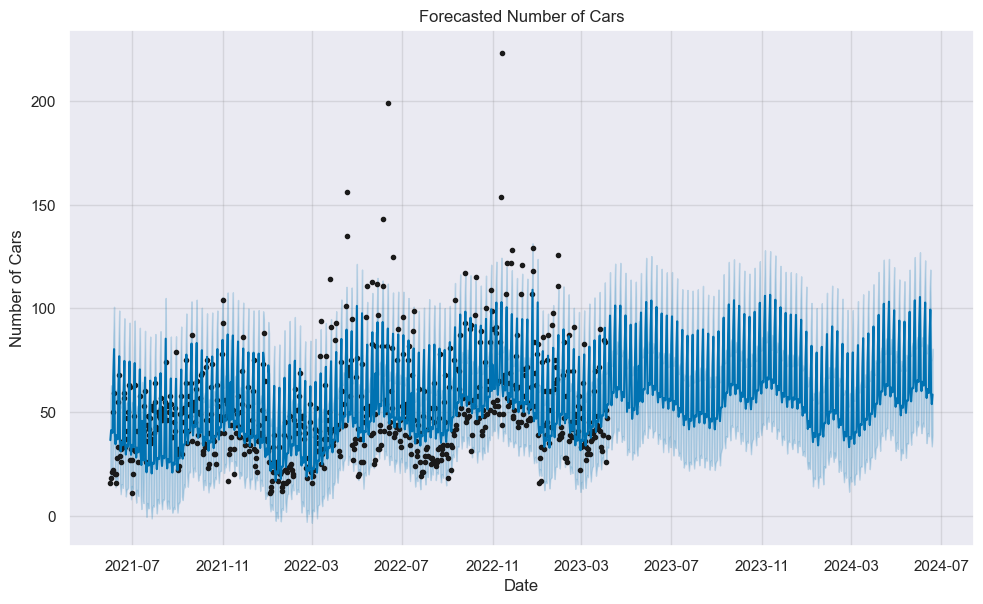

In [35]:
# Plot the graph
fig1 = model.plot(forecast)
plt.xlabel('Date')
plt.ylabel('Number of Cars')
plt.title('Forecasted Number of Cars')

plt.show()

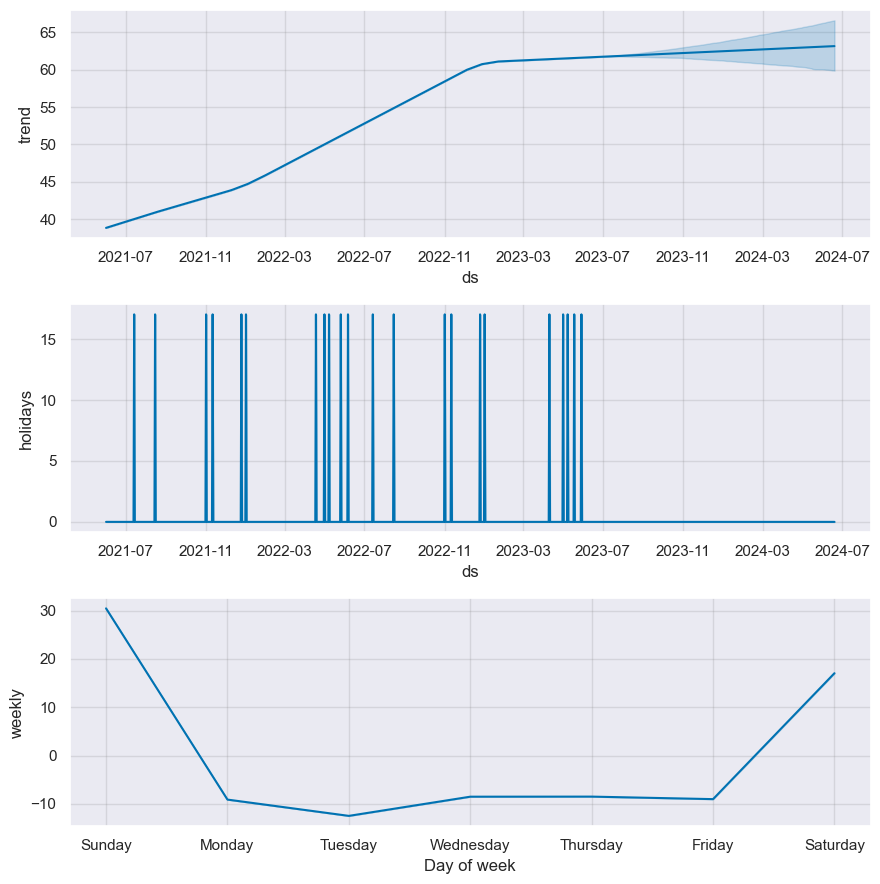

In [36]:
# Explain seasonality
fig2 = model.plot_components(forecast)


# Prophet with strikes, vacation & holidays

In [37]:
# Load prepared dataset
df_days = pd.read_csv("../prepared_data/01_06_2021_to_20_06_2023_prepared_df_206.csv")

df_days.rename(columns={'holidays': 'holiday_indicator'}, inplace=True)

df_prophet_cars = df_days[['date', 'nb_cars','holiday_indicator', 'vacation', 'strike']]
df_prophet_cars = df_prophet_cars.rename(columns={'date': 'ds', 'nb_cars': 'y'})
df_prophet_cars['holiday_indicator'].fillna(method='ffill', inplace=True)

print(df_prophet_cars.head())

df_prophet_cars['strike'] = 0  # Replace 0 with your strike data
df_prophet_cars['vacations'] = 0  # Replace 0 with your vacations data
df_prophet_cars['holiday_indicator'] = 0  # Replace 0 with your holidays data


fr_holidays = holidays.France()
df_prophet_cars['holiday_indicator'] = df_prophet_cars['ds'].apply(lambda x: x in fr_holidays)
df_prophet_cars['ds'] = pd.to_datetime(df_prophet_cars['ds'])

holidays_df = df_prophet_cars[df_prophet_cars['holiday_indicator']]
holidays_df['holiday_indicator'] = 'holiday_indicator'

# Split the dataset into train and test sets
#train_percentage = 0.9
#test_percentage = 0.1

total_rows = len(df_prophet_cars)
train_rows = int(total_rows * train_percentage)
test_rows = total_rows - train_rows

train_set = df_prophet_cars[:train_rows]
test_set = df_prophet_cars[train_rows:]

model = Prophet()
model.add_regressor('strike')
model.add_regressor('vacations')
model.add_regressor('holiday_indicator')
model.fit(df_prophet_cars)

future_test = model.make_future_dataframe(periods=365)
future_test['strike'] = 0  # Replace 0 with your strike data
future_test['vacations'] = 0  # Replace 0 with your vacations data
future_test['holiday_indicator'] = 0  # Replace 0 with your holidays data

forecast_test = model.predict(future_test)
forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

y_true_test = test_set['y']
y_pred_test = forecast_test['yhat'].tail(len(test_set))
rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

mape_test = mean_absolute_percentage_error(y_true_test, y_pred_test) * 100
print("MAPE for the test set:", mape_test)

# Calculate MAE for the test set
y_true_test = test_set['y']
y_pred_test = forecast_test['yhat'].tail(len(test_set))
mae_test = mean_absolute_error(y_true_test, y_pred_test)
print("MAE for the test set:", mae_test)

/var/folders/gn/32bg35111_q711w0ydw7_2rc0000gp/T/ipykernel_66835/2085327975.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidays_df['holiday_indicator'] = 'holiday_indicator'
22:37:52 - cmdstanpy - INFO - Chain [1] start processing
22:37:52 - cmdstanpy - INFO - Chain [1] done processing


           ds   y  holiday_indicator  vacation  strike
0  2021-06-01  16                  0         0       0
1  2021-06-02  18                  0         0       0
2  2021-06-03  21                  0         0       0
3  2021-06-04  22                  0         0       0
4  2021-06-05  50                  0         0       0
MAPE for the test set: 37.78139863435067
MAE for the test set: 21.93791374747198


In [38]:
forecast_test

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-06-01,38.861987,15.843251,55.367893,38.861987,38.861987,-2.352260,-2.352260,-2.352260,0.0,...,-13.522178,-13.522178,-13.522178,11.169918,11.169918,11.169918,0.0,0.0,0.0,36.509727
1,2021-06-02,38.889788,21.261078,60.864573,38.889788,38.889788,2.438347,2.438347,2.438347,0.0,...,-8.665153,-8.665153,-8.665153,11.103500,11.103500,11.103500,0.0,0.0,0.0,41.328135
2,2021-06-03,38.917588,20.833238,61.779338,38.917588,38.917588,2.277498,2.277498,2.277498,0.0,...,-8.662252,-8.662252,-8.662252,10.939750,10.939750,10.939750,0.0,0.0,0.0,41.195086
3,2021-06-04,38.945389,21.207511,61.965703,38.945389,38.945389,1.063244,1.063244,1.063244,0.0,...,-9.623359,-9.623359,-9.623359,10.686604,10.686604,10.686604,0.0,0.0,0.0,40.008633
4,2021-06-05,38.973189,46.276458,87.330703,38.973189,38.973189,27.868472,27.868472,27.868472,0.0,...,17.514698,17.514698,17.514698,10.353773,10.353773,10.353773,0.0,0.0,0.0,66.841661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,2024-06-15,62.954695,67.687887,105.252128,59.863015,66.304865,22.768551,22.768551,22.768551,0.0,...,17.514698,17.514698,17.514698,5.253853,5.253853,5.253853,0.0,0.0,0.0,85.723246
1111,2024-06-16,62.958489,79.275164,118.852044,59.850945,66.325522,36.319070,36.319070,36.319070,0.0,...,31.461558,31.461558,31.461558,4.857512,4.857512,4.857512,0.0,0.0,0.0,99.277559
1112,2024-06-17,62.962283,38.162245,79.097110,59.840267,66.339063,-3.992158,-3.992158,-3.992158,0.0,...,-8.503313,-8.503313,-8.503313,4.511155,4.511155,4.511155,0.0,0.0,0.0,58.970125
1113,2024-06-18,62.966077,33.531282,74.730432,59.830353,66.350914,-9.305390,-9.305390,-9.305390,0.0,...,-13.522178,-13.522178,-13.522178,4.216788,4.216788,4.216788,0.0,0.0,0.0,53.660687


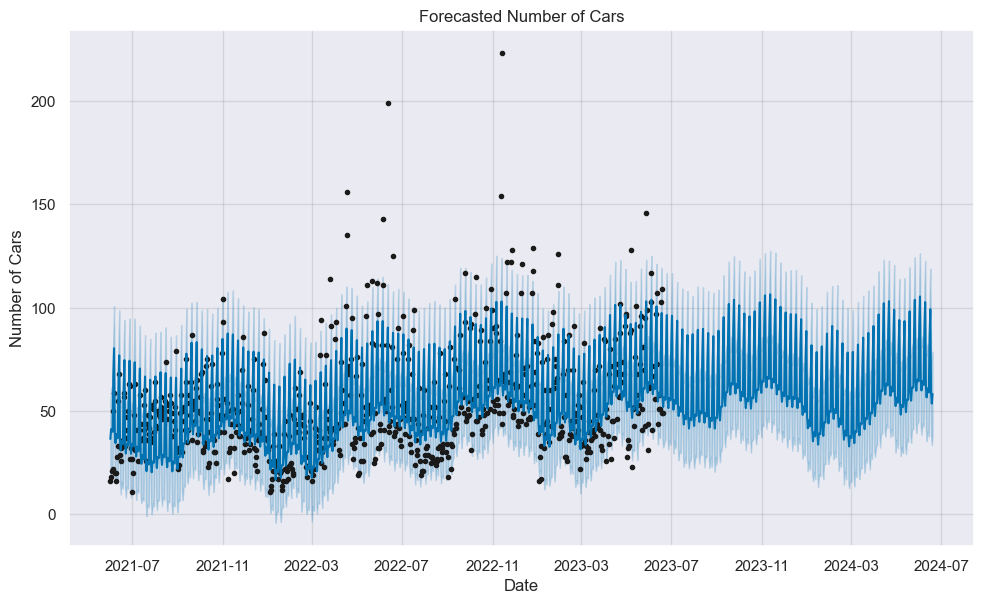

In [39]:
# Plot the graph
fig1 = model.plot(forecast_test)
plt.xlabel('Date')
plt.ylabel('Number of Cars')
plt.title('Forecasted Number of Cars')

plt.show()

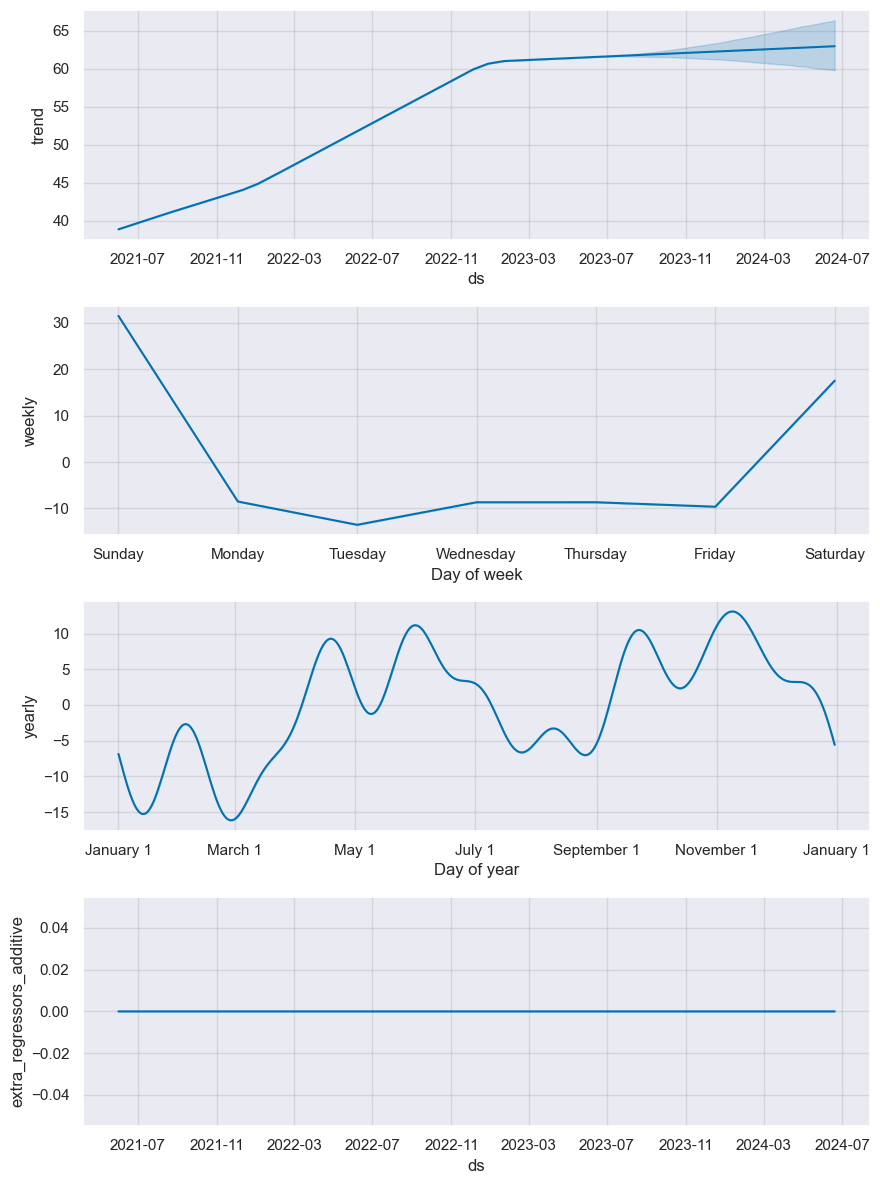

In [40]:
# Explain seasonality
fig2 = model.plot_components(forecast_test)

# Prophet with 1 booking_fees

In [41]:
# Load prepared dataset
df_days = pd.read_csv("../prepared_data/01_06_2021_to_20_06_2023_prepared_df_206.csv")


df_prophet_cars = df_days[['date', 'nb_cars','WE package']]
df_prophet_cars = df_prophet_cars.rename(columns={'date': 'ds', 'nb_cars': 'y'})

print(df_prophet_cars.head())

df_prophet_cars['WE package'] = 0  # Replace 0 with your turnover data
#df_prophet_cars['booking_fees'] = 0  # Replace 0 with your booking_fees data

#df_prophet_cars['holiday_indicator'] = df_prophet_cars['ds'].apply(lambda x: x in fr_holidays)
df_prophet_cars['ds'] = pd.to_datetime(df_prophet_cars['ds'])

# Split the dataset into train and test sets
#train_percentage = 0.9
#test_percentage = 0.1

total_rows = len(df_prophet_cars)
train_rows = int(total_rows * train_percentage)
test_rows = total_rows - train_rows

train_set = df_prophet_cars[:train_rows]
test_set = df_prophet_cars[train_rows:]

# Fit the model on the training set
model = Prophet()
model.add_regressor('WE package')
model.fit(train_set)

# Create future dates for the test set
future_test = model.make_future_dataframe(periods=len(test_set))
future_test['WE package'] = 0  # Replace 0 with your test set booking_fees data

# Generate predictions for the test set
forecast_test = model.predict(future_test)

# Calculate evaluation metrics
y_true_test = test_set['y']
y_pred_test = forecast_test['yhat'].tail(len(test_set))
rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
mape_test = mean_absolute_percentage_error(y_true_test, y_pred_test) * 100
mae_test = mean_absolute_error(y_true_test, y_pred_test)

# Print the evaluation metrics
print("RMSE for the test set:", rmse_test)
print("MAPE for the test set:", mape_test)
print("MAE for the test set:", mae_test)


22:37:53 - cmdstanpy - INFO - Chain [1] start processing


22:37:53 - cmdstanpy - INFO - Chain [1] done processing


           ds   y  WE package
0  2021-06-01  16           1
1  2021-06-02  18           0
2  2021-06-03  21           0
3  2021-06-04  22           0
4  2021-06-05  50          23
RMSE for the test set: 26.536068979021376
MAPE for the test set: 30.55195141874413
MAE for the test set: 21.904822566046825


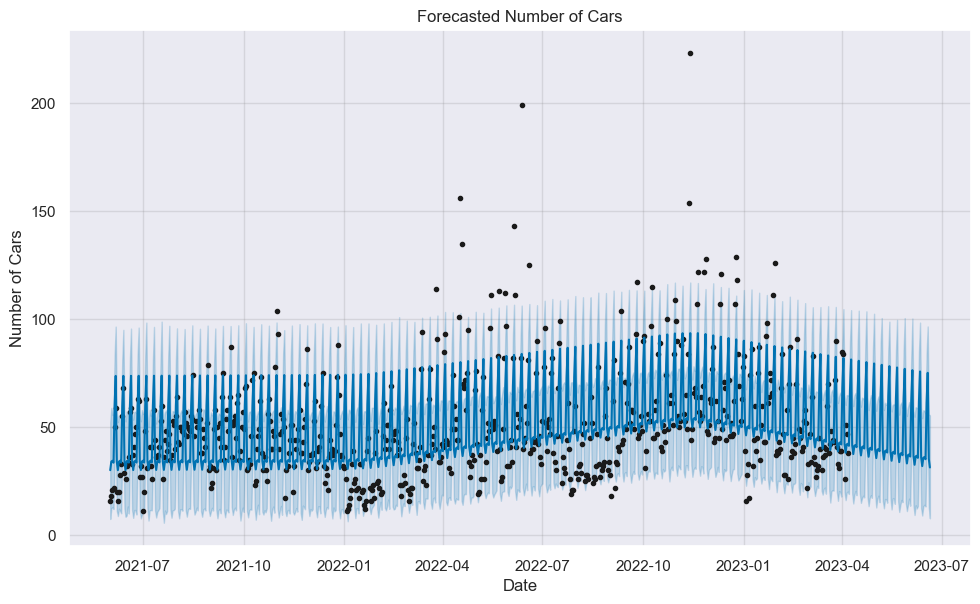

In [42]:
# Plot the graph
fig1 = model.plot(forecast_test)
plt.xlabel('Date')
plt.ylabel('Number of Cars')
plt.title('Forecasted Number of Cars')

plt.show()

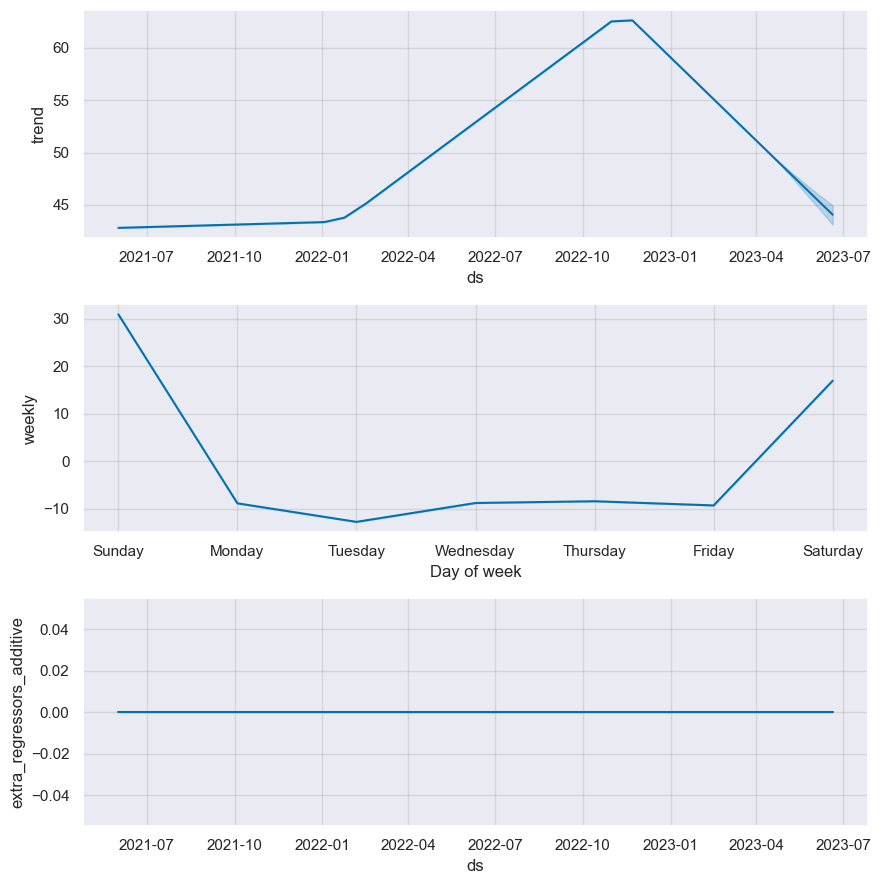

In [43]:
# Explain seasonality
fig2 = model.plot_components(forecast_test)

In [44]:
forecast_test

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,WE package,WE package_lower,WE package_upper,additive_terms,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-06-01,42.804850,7.497287,52.185726,42.804850,42.804850,0.0,0.0,0.0,-12.710598,...,0.0,0.0,0.0,-12.710598,-12.710598,-12.710598,0.0,0.0,0.0,30.094252
1,2021-06-02,42.807390,12.298197,58.919190,42.807390,42.807390,0.0,0.0,0.0,-8.742235,...,0.0,0.0,0.0,-8.742235,-8.742235,-8.742235,0.0,0.0,0.0,34.065156
2,2021-06-03,42.809930,13.001211,55.622149,42.809930,42.809930,0.0,0.0,0.0,-8.371824,...,0.0,0.0,0.0,-8.371824,-8.371824,-8.371824,0.0,0.0,0.0,34.438107
3,2021-06-04,42.812471,12.098907,56.371015,42.812471,42.812471,0.0,0.0,0.0,-9.254933,...,0.0,0.0,0.0,-9.254933,-9.254933,-9.254933,0.0,0.0,0.0,33.557537
4,2021-06-05,42.815011,35.757241,83.178416,42.815011,42.815011,0.0,0.0,0.0,16.972649,...,0.0,0.0,0.0,16.972649,16.972649,16.972649,0.0,0.0,0.0,59.787660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,2023-06-16,44.418180,13.296722,56.384682,43.529372,45.234825,0.0,0.0,0.0,-9.254933,...,0.0,0.0,0.0,-9.254933,-9.254933,-9.254933,0.0,0.0,0.0,35.163247
746,2023-06-17,44.329732,38.866976,84.247359,43.429713,45.168682,0.0,0.0,0.0,16.972649,...,0.0,0.0,0.0,16.972649,16.972649,16.972649,0.0,0.0,0.0,61.302381
747,2023-06-18,44.241283,52.291452,96.623568,43.336919,45.101311,0.0,0.0,0.0,30.918943,...,0.0,0.0,0.0,30.918943,30.918943,30.918943,0.0,0.0,0.0,75.160226
748,2023-06-19,44.152835,12.792462,55.926966,43.223984,45.032076,0.0,0.0,0.0,-8.812002,...,0.0,0.0,0.0,-8.812002,-8.812002,-8.812002,0.0,0.0,0.0,35.340832


In [45]:
# Load prepared dataset
df_days = pd.read_csv("../prepared_data/01_06_2021_to_20_06_2023_prepared_df_5435.csv")


df_prophet_cars = df_days[['date', 'nb_cars','nb_cars_cxl', 'booking_fees']]
df_prophet_cars = df_prophet_cars.rename(columns={'date': 'ds', 'nb_cars': 'y'})

print(df_prophet_cars.head())

df_prophet_cars['turnover'] = 0  # Replace 0 with your turnover data
df_prophet_cars['booking_fees'] = 0  # Replace 0 with your booking_fees data

df_prophet_cars['holiday_indicator'] = df_prophet_cars['ds'].apply(lambda x: x in fr_holidays)
df_prophet_cars['ds'] = pd.to_datetime(df_prophet_cars['ds'])

model = Prophet()
model.add_regressor('turnover')
model.add_regressor('booking_fees')
model.fit(df_prophet_cars)

future = model.make_future_dataframe(periods=365)
future['turnover'] = 0  # Replace 0 with your strike data
future['booking_fees'] = 0  # Replace 0 with your vacations data


forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

y_true_test = test_set['y']
y_pred_test = forecast_test['yhat'].tail(len(test_set))
rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

mape_test = mean_absolute_percentage_error(y_true_test, y_pred_test) * 100
print("MAPE for the test set:", mape_test)

# Calculate MAE for the test set
y_true_test = test_set['y']
y_pred_test = forecast_test['yhat'].tail(len(test_set))
mae_test = mean_absolute_error(y_true_test, y_pred_test)
print("MAE for the test set:", mae_test)

22:37:54 - cmdstanpy - INFO - Chain [1] start processing
22:37:54 - cmdstanpy - INFO - Chain [1] done processing


           ds   y  nb_cars_cxl  booking_fees
0  2021-06-01  31            2           0.0
1  2021-06-02  26            2           0.0
2  2021-06-03  28            2           0.0
3  2021-06-04  29            2           0.0
4  2021-06-05  42            2           0.0
MAPE for the test set: 30.55195141874413
MAE for the test set: 21.904822566046825
